In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

def h1n1_data_reader(filename='process_data.csv'):
    data = pd.read_csv(filename)
    X = data.drop(['h1n1_vaccine','respondent_id','seasonal_vaccine'],axis = 1)
    y =  data['h1n1_vaccine']
    return X, y


In [2]:
# from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score,f1_score
# from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')
def classification_kpi(G,S):
    """_summary_

    Args:
        G (nx.Graph): _description_
        S (list): list of nodes (list of columns)
    """
    cols = list(S)
    if len(cols) == 0:
        return 0
    else:
        
        X_train, X_test, y_train, y_test = train_test_split(X[cols], y, test_size=0.2, random_state=42)
        
        mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=3, activation='relu', random_state=42)
        mlp.fit(X_train, y_train)
        y_pred = mlp.predict(X_test)       
        
        
        f1 = f1_score(y_test, y_pred)
        return f1

In [3]:
# import shapG and necessary libraries
import networkx as nx
import shapG.shapley as shapley
import shapG.plot as shapGplot
import seaborn
from shapG.utils import corr_generator, create_minimal_edge_graph, matrix_generator, kl, kl_mi_matrix
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr,kendalltau,spearmanr
from scipy.spatial.distance import cosine


In [4]:
def get_rank(method, X, y):
    # small p-value (<0.05) no there is a correlation between the two variables
    # high p-value (>0.05) no there is no correlation between the two variables
    # sort p-value in Descending order; delete one by one
    # high cosine means high similarity (with target variable, good feature)
    # small cosine means more orthogonal
    # sort cosine similarity in ascending order; delete one by one
    if method in [pearsonr, kendalltau, spearmanr]:
        reverse = True
    elif method in [cosine]:
        reverse = False
    else:
        raise ValueError("{method.__name__} not supported")
    values = {}
    for col in X.columns:
        if reverse:
            values[col] = method(X[col], y)[1]
        else:
            values[col] = method(X[col], y)
    # get the key by descending order
    values_key = sorted(values, key=values.get, reverse=reverse)
    return values_key
def delete_by_rank(W, values_rank, ratio, reverse=True):  
    # Initialize  
    edges = []  
    columns = W.columns.tolist()  
    n_nodes = len(columns)  
    floor_ratio = (n_nodes - 1) / (n_nodes * (n_nodes - 1)) / 2
    if ratio < floor_ratio:  
        raise ValueError('The ratio is too small, the minimum ratio is {}'.format(floor_ratio))  
    
    # Collect and sort edges  
    for i in range(len(columns)):  
        for j in range(i + 1, len(columns)):  
            edges.append((columns[i], columns[j], abs(W.iloc[i, j])))  
    edges.sort(key=lambda x: x[2], reverse=reverse)  
    
    # Create graph from edges  
    G = nx.Graph()  
    G.add_weighted_edges_from([(u, v, weight) for u, v, weight in edges])  

    # Ensure the initial graph is connected  
    if not nx.is_connected(G):  
        raise ValueError("Initial graph is not connected")  
    
    max_edges = (n_nodes * (n_nodes - 1)) // 2  
    target_edges = int(ratio * max_edges)  # Since we divide by 2 for undirected graph edge count  
    
    # Function to calculate current density from edge count  
    def current_density(edges_count):  
        return 2 * edges_count / (n_nodes * (n_nodes - 1))  

    # Edge deletion following values_rank ensuring connectivity and density  
    for node in values_rank:  
        if G.number_of_edges() <= target_edges:  
            break  
        
        # Collect edges to remove and sort by weight with DESC order
        edges_to_remove = [(u, v) for u, v in G.edges(node)]
        edges_to_remove.sort(key=lambda x: G[x[0]][x[1]]["weight"], reverse=True)
        for edge in edges_to_remove:  
            if G.number_of_edges() <= target_edges:  
                break  
            # Temporarily remove edge  
            weight = G[edge[0]][edge[1]]["weight"]
            G.remove_edge(*edge)  
            # Check if graph remains connected  
            if nx.is_connected(G):  
                # Check if the current density is acceptable  
                if current_density(G.number_of_edges()) >= ratio:  
                    continue  # Edge removal is valid  
                else:  
                    # Add edge back since density fell below target ratio  
                    G.add_edge(*edge, weight=weight)  
            else:  
                # Add edge back to keep the graph connected  
                G.add_edge(*edge,weight=weight)  
    edges_result = [(u, v, G[u][v]['weight']) for u, v in G.edges()]  
    return edges_result 

def run_with_ratio(X, y, ratio, method):
    values_rank = get_rank(method, X, y)
    W = matrix_generator(X, method)
    G = nx.Graph(W)
    plt.subplot(121)
    nx.draw_shell(G, with_labels=True)
    plt.title('Original Graph')
    mst = delete_by_rank(W, values_rank, ratio)
    G2 = nx.Graph()
    G2.add_weighted_edges_from(mst)
    plt.subplot(122)
    nx.draw_shell(G2, with_labels=True)
    plt.title("Graph after {:.2f}% remained".format(ratio*100))
    shapley_values = shapley.shapG(G2, m=3, f=classification_kpi, approximate_by_ratio=False)
    sorted_values = sorted(shapley_values.items(), key=lambda item: item[1], reverse=True)
    shapGplot.plot(shapley_values, top_n=15)
    return sorted_values

In [5]:
def run_on_different_ratio(X, y, limit, method, step=0.10):
    n_nodes = len(X.columns)
    rsts = {}
    floor_ratio = (n_nodes - 1) / (n_nodes * (n_nodes - 1)) / 2
    ratio = floor_ratio
    while ratio < limit:
        print(f"Processing ratio {ratio:.2f}")
        rst = {}
        start_time = time.time()
        sorted_values = run_with_ratio(X, y, ratio, method)
        duration = time.time() - start_time
        rst['values'] = sorted_values
        rst['duration'] = duration
        rsts[f"{method.__name__}-{ratio:.2f}" ] = rst
        ratio += step
    return rsts

Processing ratio 0.01


100%|███████████████████████████████████████████| 35/35 [02:01<00:00,  3.47s/it]


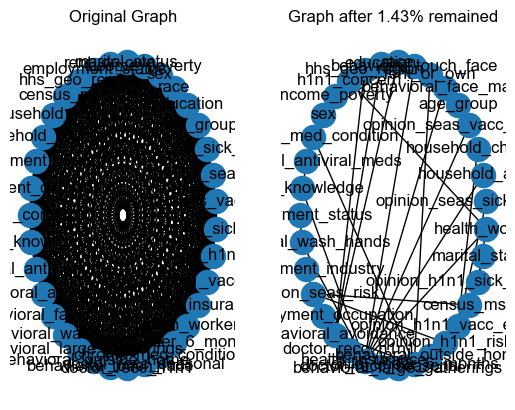

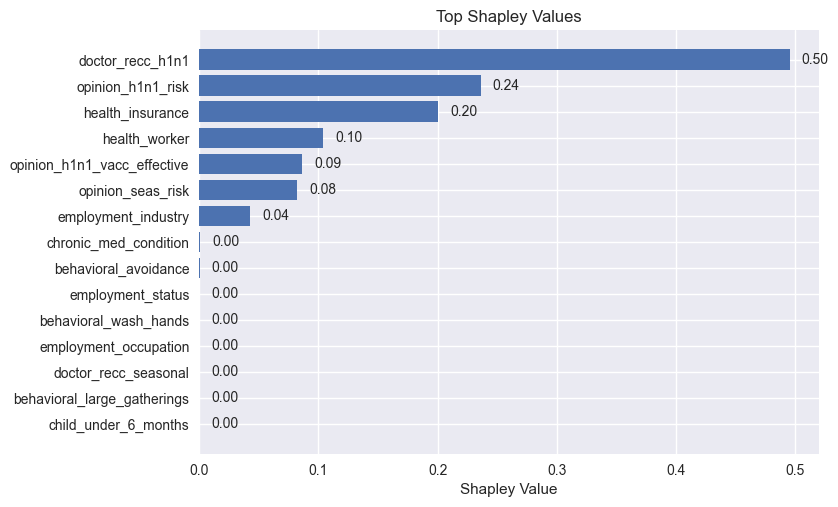

Processing ratio 0.06


100%|███████████████████████████████████████████| 35/35 [01:54<00:00,  3.28s/it]


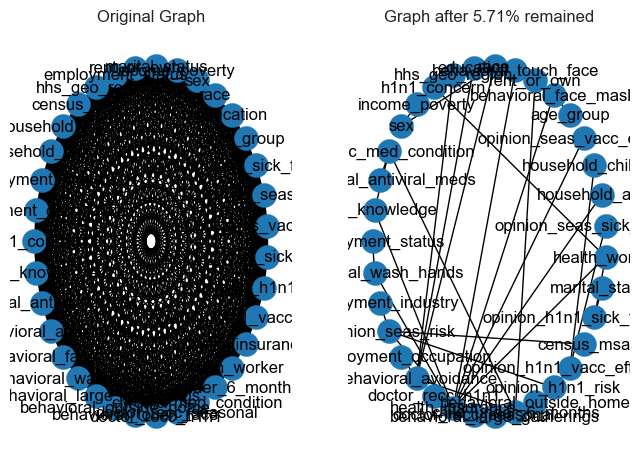

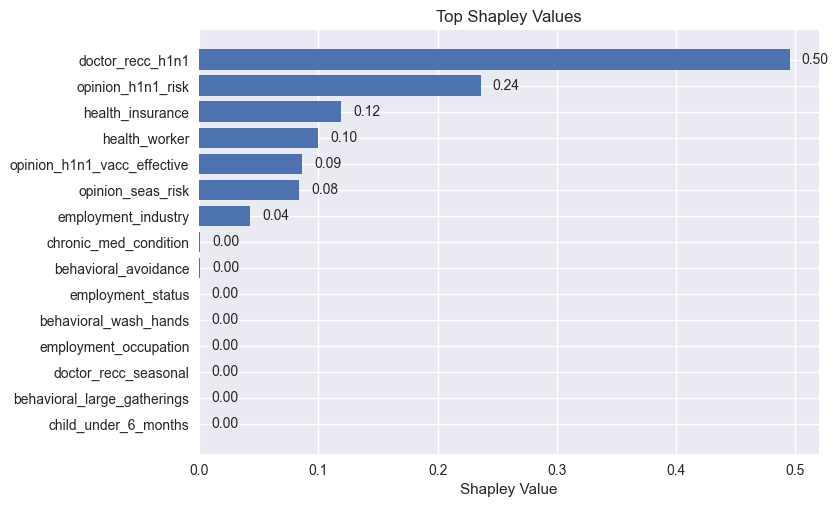

Processing ratio 0.10


100%|███████████████████████████████████████████| 35/35 [05:14<00:00,  8.98s/it]


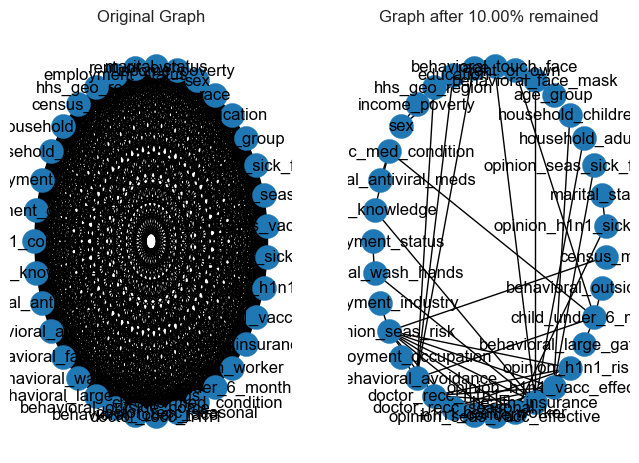

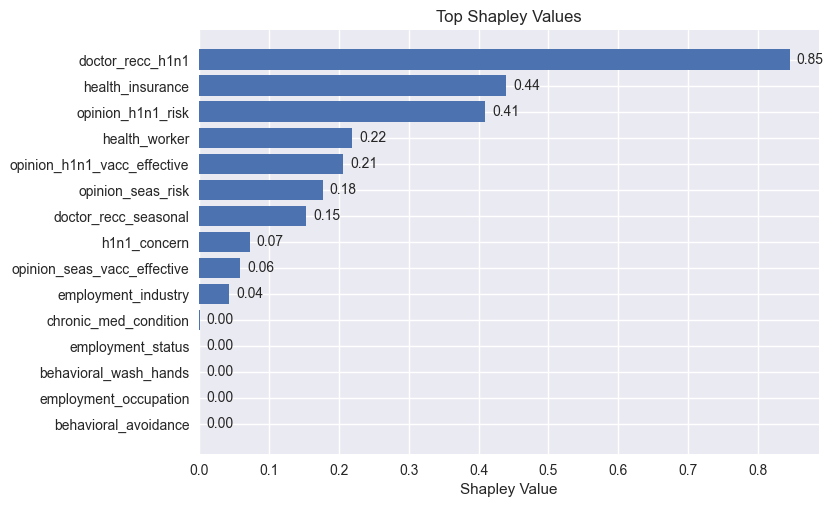

Processing ratio 0.14


100%|███████████████████████████████████████████| 35/35 [09:26<00:00, 16.20s/it]


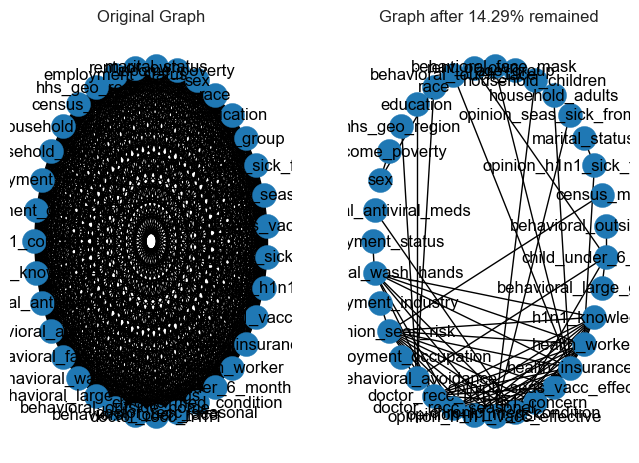

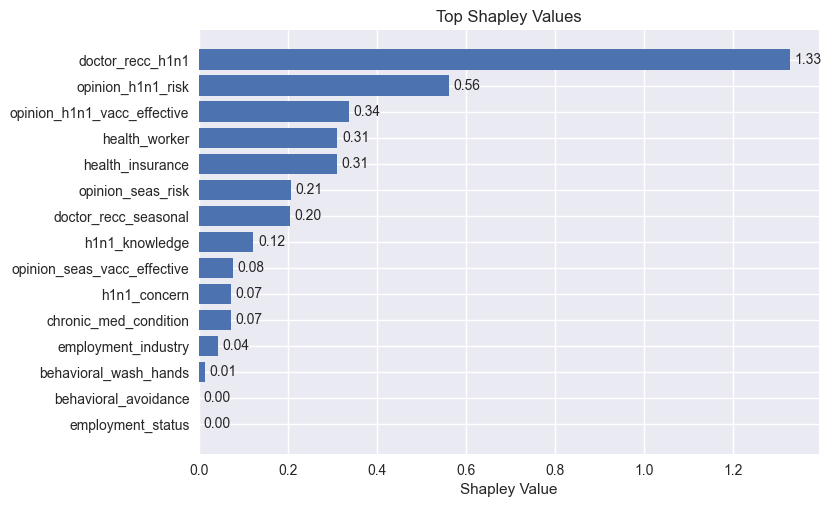

Processing ratio 0.19


100%|███████████████████████████████████████████| 35/35 [14:56<00:00, 25.63s/it]


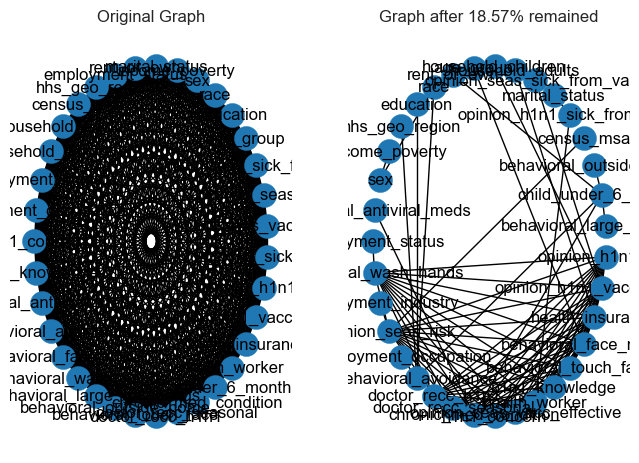

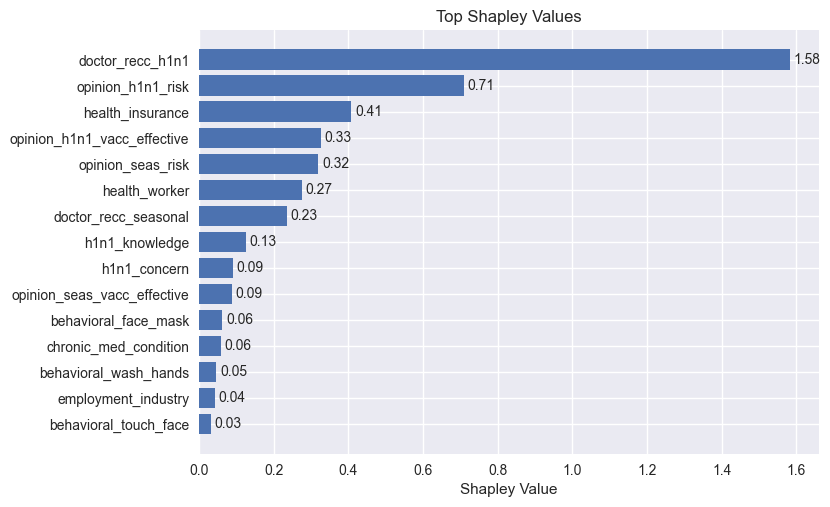

In [6]:
X, y = h1n1_data_reader('process_data.csv')

rsts = {}
n_nodes = len(X.columns)
floor_ratio = (n_nodes - 1) / (n_nodes * (n_nodes -1)) / 2
epoch = 5
step_size = floor_ratio * 3
limit = floor_ratio + epoch * step_size
# rsts['pearsonr'] = run_on_different_ratio(X, y, limit, pearsonr, step=step_size)
rsts['kendalltau'] = run_on_different_ratio(X, y, limit, kendalltau, step=step_size)
# rsts['spearmanr'] = run_on_different_ratio(X, y, limit, spearmanr, step=step_size)
# rsts['cosine'] = run_on_different_ratio(X, y, limit, cosine, step=step_size)

In [7]:
rsts

{'kendalltau': {'kendalltau-0.01': {'values': [('doctor_recc_h1n1',
     0.4952604052322386),
    ('opinion_h1n1_risk', 0.23609173244545695),
    ('health_insurance', 0.20057500137321593),
    ('health_worker', 0.10413106005300139),
    ('opinion_h1n1_vacc_effective', 0.08622761148077503),
    ('opinion_seas_risk', 0.08223414031244711),
    ('employment_industry', 0.04262295081967213),
    ('chronic_med_condition', 0.0008818342151675485),
    ('behavioral_avoidance', 0.0003529657518009081),
    ('employment_status', 0.0),
    ('behavioral_wash_hands', 0.0),
    ('employment_occupation', 0.0),
    ('doctor_recc_seasonal', 0.0),
    ('behavioral_large_gatherings', 0.0),
    ('child_under_6_months', 0.0),
    ('behavioral_outside_home', 0.0),
    ('census_msa', 0.0),
    ('opinion_h1n1_sick_from_vacc', 0.0),
    ('marital_status', 0.0),
    ('opinion_seas_sick_from_vacc', 0.0),
    ('household_adults', 0.0),
    ('household_children', 0.0),
    ('opinion_seas_vacc_effective', 0.0),
    ('

In [8]:
for k, v in rsts.items():
    for kk, vv in v.items():
        print(f"{kk}: {vv['duration']:.2f} seconds")
        rank = [x[0] for x in vv['values']]
        print("feature ranking:", rank)

kendalltau-0.01: 123.13 seconds
feature ranking: ['doctor_recc_h1n1', 'opinion_h1n1_risk', 'health_insurance', 'health_worker', 'opinion_h1n1_vacc_effective', 'opinion_seas_risk', 'employment_industry', 'chronic_med_condition', 'behavioral_avoidance', 'employment_status', 'behavioral_wash_hands', 'employment_occupation', 'doctor_recc_seasonal', 'behavioral_large_gatherings', 'child_under_6_months', 'behavioral_outside_home', 'census_msa', 'opinion_h1n1_sick_from_vacc', 'marital_status', 'opinion_seas_sick_from_vacc', 'household_adults', 'household_children', 'opinion_seas_vacc_effective', 'age_group', 'behavioral_face_mask', 'rent_or_own', 'behavioral_touch_face', 'race', 'education', 'hhs_geo_region', 'h1n1_concern', 'income_poverty', 'sex', 'behavioral_antiviral_meds', 'h1n1_knowledge']
kendalltau-0.06: 116.57 seconds
feature ranking: ['doctor_recc_h1n1', 'opinion_h1n1_risk', 'health_insurance', 'health_worker', 'opinion_h1n1_vacc_effective', 'opinion_seas_risk', 'employment_industry

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
# from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import lightgbm as lgb

In [10]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
# Setting the custom styling and markers as per your request
plt.rcParams['font.family'] = 'cmu-serif'  # Adjusted due to 'cmu-serif' not found
plt.rcParams['text.usetex'] = True  # Disabled LaTeX rendering due to environment constraints
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=['#9400d3', '#009e73', '#56b4e9', '#e69f00', '#f0e442', '#0072b2', '#e51e10', '#000000'])
plt.rcParams["legend.frameon"] = True
# markers = ['+','x','*','s','s','.','.','^','^','v','v','D','D','p']
markers = ['+','x','*','s','.','^','v','D','p']

def plot_feature_dropping_effects(X, y, method2dict, limit=10, plot_title='Comparison of accuracy after dropping features (LightGBM)', filename=None):  
    """  
    Function to plot the effect on prediction accuracy of dropping features based on various ratios of method2dict.  
    
    Parameters:  
    X (DataFrame): Feature matrix.  
    y (Series/DataFrame): Target variable.  
    method2dict (dict): Dictionary containing feature ranks and other details.  
    model: Machine learning model to be used for predictions.  
    plot_title (str): Title for the plot.  
    
    Returns:  
    Results (dict): Dictionary containing the features dropped and corresponding accuracies for each ratio value from method2dict.  
    """  
    x_train, x_test, y_train, y_test = train_test_split(X, y ,test_size= 0.2, random_state= 10)
    model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=3, activation='relu', random_state= 42)

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    initial_accuracy = accuracy_score(y_test, y_pred)
    results = {}

    plt.figure(figsize=(12, 8))
    method_marker_map = {method: markers[i % len(markers)] for i, method in enumerate(method2dict)}  

    for method, rst_dict in method2dict.items():
        for idx, (k, v) in enumerate(rst_dict.items()):  
            accuracies = [initial_accuracy]  
            features = [[]]  
            feature_rank = [x[0] for x in v['values']]  
            
            for i in range(1, limit):  
                features_to_drop = feature_rank[:i]  
                reduced_X = X.drop(columns=features_to_drop)  
                
                x_train, x_test, y_train, y_test = train_test_split(reduced_X, y, test_size=0.2, random_state=10)  
                
                model.fit(x_train, y_train)  
                y_pred = model.predict(x_test)  
                
                new_accuracy = accuracy_score(y_test, y_pred)  
                accuracies.append(new_accuracy)  
                features.append(features_to_drop)  
            
            results[k] = {'Features': features, 'Accuracies': accuracies}  
            
            plt.plot(range(0, limit), accuracies, marker=method_marker_map[method], label=k, linewidth=1, alpha=0.7)  
    
    plt.xlabel('Number of Features Dropped')  
    plt.ylabel('accuracy')  
    plt.title(plot_title)  
    plt.xticks(range(0, limit))  
    plt.legend()
    plt.grid()
    if filename != None:
        plt.savefig(filename, format='eps', dpi=300)
    plt.show() 

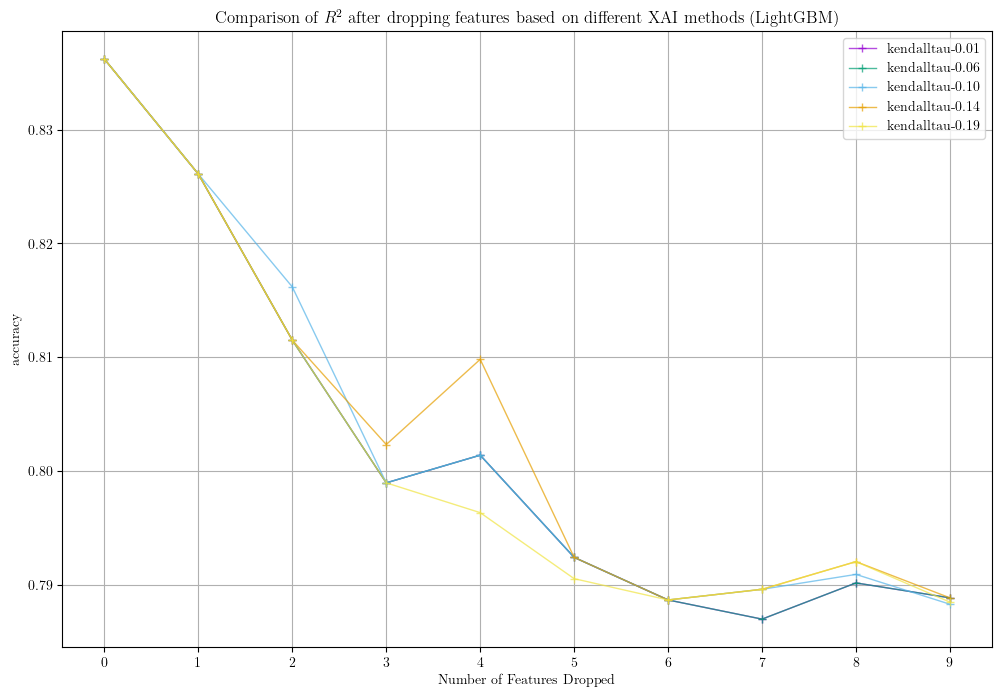

In [11]:

X, y = h1n1_data_reader('process_data.csv')

plot_feature_dropping_effects(X, y, rsts, limit=10, plot_title='Comparison of $R^2$ after dropping features based on different XAI methods (LightGBM)')  


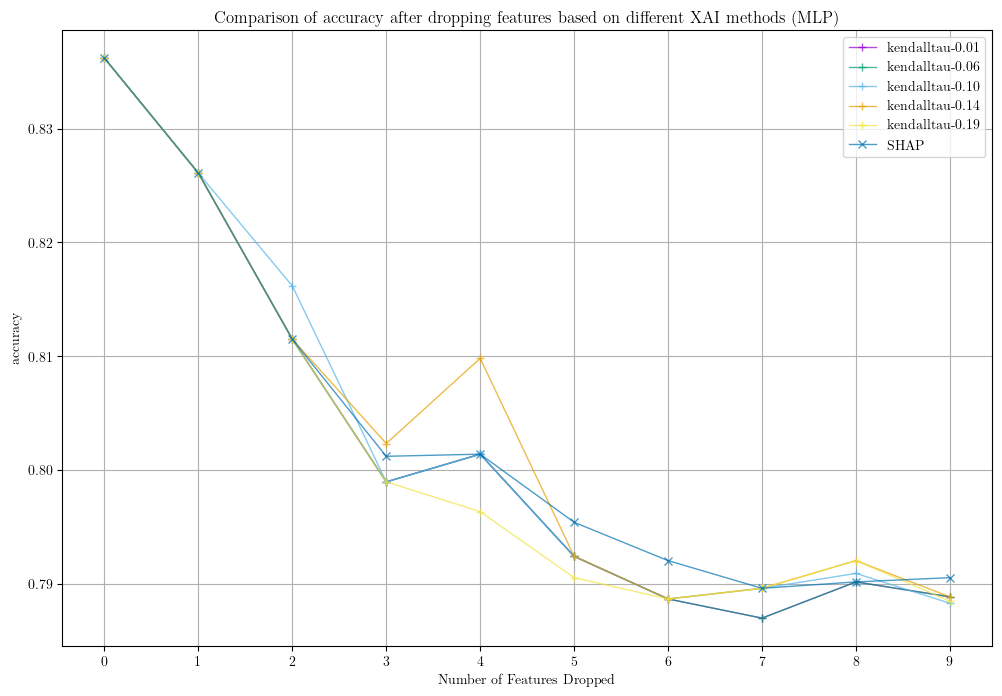

In [12]:
# manually add another results
rsts['SHAP'] = {'SHAP': {'values': [('doctor_recc_h1n1', 2.831461878407962),
('opinion_h1n1_risk', 1.3216669229152027),
 ('doctor_recc_seasonal', 0.3424220013810476),
 ('health_insurance', 0.33123111371038527),
 ('health_worker', 0.3306408796027438),
 ('opinion_h1n1_vacc_effective', 0.3229029592729431),
 ('opinion_seas_risk', 0.3144247295230614),
 ('opinion_seas_vacc_effective', 0.1504121131059761),
 ('employment_occupation', 0.14450476766648576),
 ('h1n1_knowledge', 0.11604639715530543),
 ('h1n1_concern', 0.08730886106306036),
 ('chronic_med_condition', 0.07921150049392757),
 ('child_under_6_months', 0.05637333521186078),
('opinion_h1n1_sick_from_vacc', 0.05319369354218418),
('behavioral_wash_hands', 0.042225312314515),
 ('opinion_seas_sick_from_vacc', 0.041693518454734256)],
   'duration': 11.636922121047974}}
plot_feature_dropping_effects(X, y, rsts, limit=10, plot_title='Comparison of accuracy after dropping features based on different XAI methods (MLP)')  

In [15]:
def compute_weighted_slope(X, y, method2dict, limit=11):
    """
    Function to calculate weighted slopes of decrease in prediction accuracy after dropping features.

    Parameters:
    X (DataFrame): Feature matrix.
    y (Series/DataFrame): Target variable.
    method2dict (dict): Dictionary containing feature ranks and other details.

    Returns:
    Results (dict): Dictionary containing the weighted sum of slopes for each ratio value from method2dict.
    """
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=3, activation='relu', random_state= 42)
  
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    initial_accuracy = accuracy_score(y_test, y_pred)
    results = {}

    for method, rst_dict in method2dict.items():
        print(f"\nMethod: {method}")  # 输出当前方法
        for idx, (k, v) in enumerate(rst_dict.items()):
            accuracies = [initial_accuracy]
            slopes = []
            feature_rank = [x[0] for x in v['values']]

            for i in range(1, limit):
                features_to_drop = feature_rank[:i]
                reduced_X = X.drop(columns=features_to_drop)

                x_train, x_test, y_train, y_test = train_test_split(reduced_X, y, test_size=0.2, random_state=10)

                model.fit(x_train, y_train)
                y_pred = model.predict(x_test)

                new_accuracy = accuracy_score(y_test, y_pred)
                accuracies.append(new_accuracy)

                # 计算斜率：新精度与前一精度之间的差异
                slope = (accuracies[-2] - new_accuracy)
                slopes.append(slope)

            # 计算加权斜率
            weights = np.linspace(1, 0.1, num=limit-1)  # 权重从1递减到0.1
            weighted_slopes = np.array(slopes) * weights
            total_weighted_slope = np.sum(weighted_slopes)
            rst_dict[k]['Slope'] = total_weighted_slope
            results[k] = total_weighted_slope

            # 打印加权斜率结果
            print(f"Rank: {k}, Weighted Slope: {total_weighted_slope}")

    return results, method2dict

In [16]:
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

X, y = h1n1_data_reader()
_, new_rsts = compute_weighted_slope(X, y, rsts, limit=11)


Method: kendalltau
Rank: kendalltau-0.01, Weighted Slope: 0.038730812429801545
Rank: kendalltau-0.06, Weighted Slope: 0.038730812429801545
Rank: kendalltau-0.10, Weighted Slope: 0.0383002620741295
Rank: kendalltau-0.14, Weighted Slope: 0.03747660052414822
Rank: kendalltau-0.19, Weighted Slope: 0.03938599775365028

Method: SHAP
Rank: SHAP, Weighted Slope: 0.037551478846873806


In [25]:
values_rank = get_rank(kendalltau, X, y)
W = matrix_generator(X, kendalltau)
mst = delete_by_rank(W, values_rank, 0.19)
G = nx.Graph(W)
# 创建 G2
G2 = nx.Graph()
density = nx.density(G2)
G2.add_weighted_edges_from(mst)


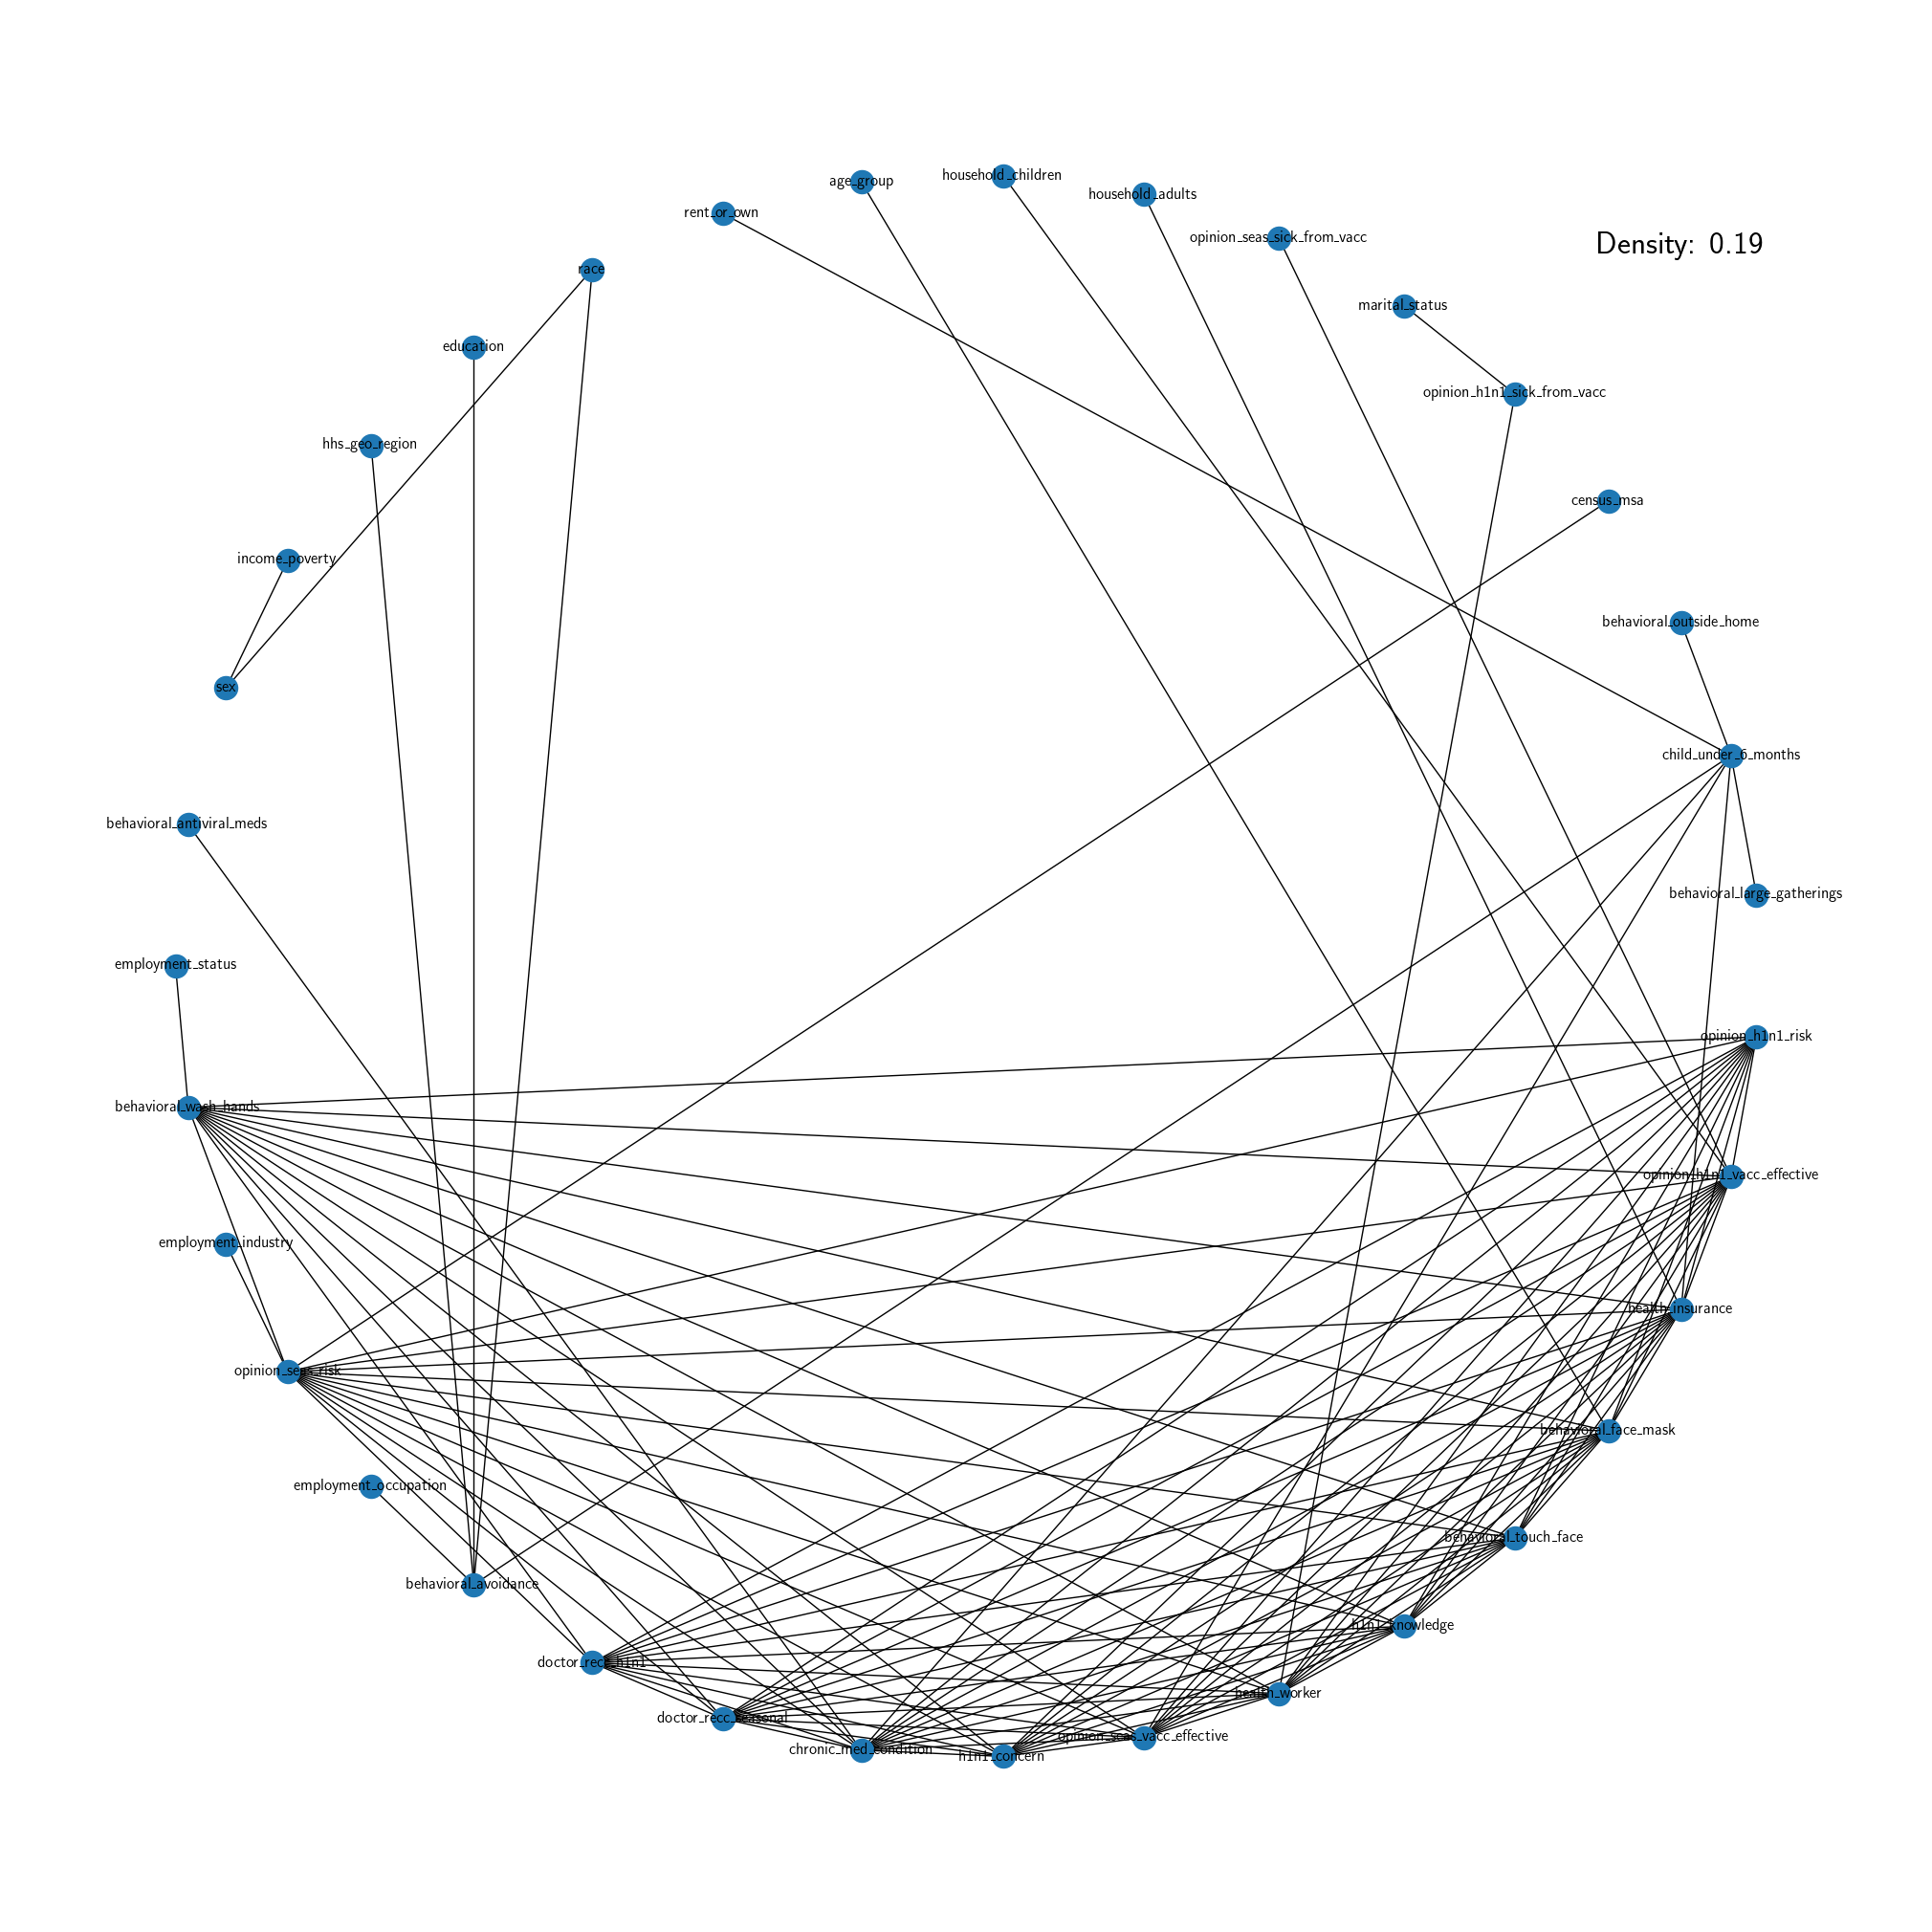

In [27]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.figure(figsize=(20, 20))  # 设置图形大小
nx.draw_shell(G2, with_labels=True)  # 使用 shell 布局绘制 G2
plt.text(0.9, 0.9, f"Density: 0.19", fontsize=24, fontfamily='Arial', ha='center')
# plt.title("Graph after {:.2f}% remained".format(0.16 * 100))  # 添加标题
plt.savefig('graph_improved_mlp.eps', format='eps', dpi=300)
plt.show() 

In [20]:
import matplotlib.pyplot as plt

# 查看默认字体家族
print("Default font family:", plt.rcParams['font.family'])

# 查看默认字体名称
print("Default font name:", plt.rcParams['font.sans-serif'][0])

Default font family: ['cmu-serif']
Default font name: DejaVu Sans
